In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy import spatial
import xarray as xr

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

In [53]:
# to do: select only the applicable date from L4 
#    and try restrict lats and lons of l2 dataset

l4 = xr.open_dataset('../Data/cci_sst.nc')
l4 = l4.sel(time=slice('2009-12-18','2009-12-18'))

l2 = xr.open_dataset('../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_20081218.nc')

l3 = xr.open_dataset('../Data/TSST/ESA_CCI_L3U_AATSR_20081218.nc')

In [11]:
# l2_sel = l2.where(l2['latitude'] <= -10 and l2['latitude'] >= -50)
l2_sel = l2.where(l2['latitude'] <= -10)
l2_sel = l2.where(l2['latitude'] >= -50)
# l2.where(l2['latitude'].isin([-50, -10]), drop=True)


In [29]:
l2_sel = l2.where((l2['latitude'] <= -10) & (l2['latitude'] >= -50))
l2_sel = l2_sel.where((l2_sel['longitude'] <= 70) & (l2_sel['longitude'] >= 0))
l2_sel_arr = l2_sel.to_array()
# l2_sel = np.delete(l2_sel.to_array(), np.where(l2_sel['latitude'] == np.nan))

In [43]:
l2_sel_arr = np.delete(l2_sel_arr[1,], np.where(l2_sel_arr[1,] == np.nan))
# l2_sel_arr[1,]

In [44]:
l2_sel_arr

<xarray.DataArray (num_observations: 4436979)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    variable  <U18 'longitude'
Dimensions without coordinates: num_observations

In [12]:
l2_sel['latitude'].data.shape

(4436979,)

In [13]:
l2

<xarray.Dataset>
Dimensions:             (num_observations: 4436979)
Dimensions without coordinates: num_observations
Data variables:
    latitude            (num_observations) float32 63.367184 ... 69.004875
    longitude           (num_observations) float32 -19.831053 ... -53.650387
    along_track_SST     (num_observations) float32 ...
    standard_deviation  (num_observations) float32 ...
    hour                (num_observations) float32 ...
    minute              (num_observations) float32 ...
    second              (num_observations) float32 ...
Attributes:
    title:         Processed along-track ESA CCI L2P SST data from AVHRRMTA_G...
    source:        ESA CCI SST http://data.ceda.ac.uk/neodc/esacci/sst
    references:    https://github.com/sanAkel/Harry_uCapeTown/tree/master/ESA...
    date_created:  Year 2020

# Plot along-track point obs

## L2

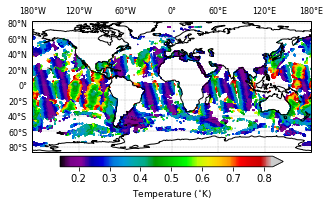

<Figure size 432x288 with 0 Axes>

In [61]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

#gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# img = hycom_free_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
img = plt.scatter(l2['longitude'], l2['latitude'], s=0.05, c=l2['standard_deviation'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'))
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Temperature ($^{\circ}$K)', fontsize=9)

ax.set_title('')
# plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/vel/VEL_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

## L3

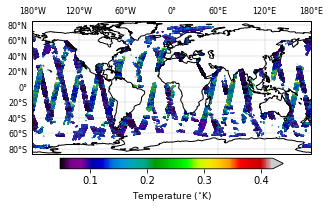

<Figure size 432x288 with 0 Axes>

In [62]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

#gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# img = hycom_free_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
img = plt.scatter(l3['longitude'], l3['latitude'], s=0.05, c=l3['standard_deviation'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'))
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Temperature ($^{\circ}$K)', fontsize=9)

ax.set_title('')
# plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/vel/VEL_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

# Plot differences between L4 and TSSTs

## L4 vs L2

In [64]:
'''

The KDTree method used below is outlined at the link below:
   https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/KDTree_nearest_neighbor.ipynb
with some minor modifications in order to produce the differences.

'''

# Create meshgrid for use with KDTree
x,y = np.meshgrid(*(l4['lon'], l4['lat']))

# Build KDTree from L4 grid
tree = spatial.KDTree(np.column_stack([x.ravel(), y.ravel()]))
# obs_tree = spatial.KDTree(l4['analysed_sst'])

# Gather obs coordinates into a numpy column stack
obs_points = np.column_stack([l2['longitude'], l2['latitude']])

# Obtain distances between L2 obs and nearest L4 cell and the index of the L4 cell as
#   recorded in the KDTree object (tree). Setting upper bound limits distances between
#   L2 obs and L4 cells and will speed up the operation.
dist, idx = tree.query(obs_points, distance_upper_bound=0.05)

# Squeeze L4 SSTs and then stack to obtain vector of temperatures to match shape of
#   L2 observations for easy differencing
l4_VecErrs = l4['analysis_uncertainty'].squeeze().stack(vectored=['lon', 'lat'])

# Obtain the difference between the L2 obs and the nearest L4 cell
error_diff_l2 = l2['standard_deviation'] - l4_VecErrs[idx-1].data

In [87]:
print('%s out of %s stations within the distance threshold' % (len(dist[dist!=np.inf]), len(dist)))

268379 out of 4436979 stations within the distance threshold


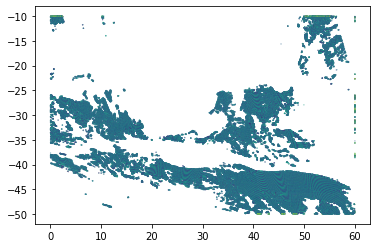

In [65]:
xs = tree.data[idx-1][:,0]
ys = tree.data[idx-1][:,1]
plt.scatter(xs, ys, s=0.05, c=dist)

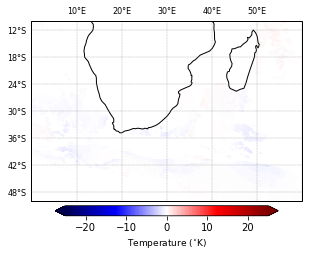

<Figure size 432x288 with 0 Axes>

In [66]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_extent([0, 60, -50, -10], ccrs.PlateCarree())

#gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# img = hycom_free_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
img = plt.scatter(l2['longitude'], l2['latitude'], s=0.05, c=error_diff_l2, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), vmin=-25, vmax=25)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('Temperature ($^{\circ}$K)', fontsize=9)

ax.set_title('')
# plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/vel/VEL_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

## L4 vs L3

In [68]:
'''

The KDTree method used below is outlined at the link below:
   https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/KDTree_nearest_neighbor.ipynb
with some minor modifications in order to produce the differences.

'''

# Create meshgrid for use with KDTree
x,y = np.meshgrid(*(l4['lon'], l4['lat']))

# Build KDTree from L4 grid
tree = spatial.KDTree(np.column_stack([x.ravel(), y.ravel()]))
# obs_tree = spatial.KDTree(l4['analysed_sst'])

# Gather obs coordinates into a numpy column stack
obs_points = np.column_stack([l3['longitude'], l3['latitude']])

# Obtain distances between L3 obs and nearest L4 cell and the index of the L4 cell as
#   recorded in the KDTree object (tree). Setting upper bound limits distances between
#   L3 obs and L4 cells and will speed up the operation.
dist, idx = tree.query(obs_points, distance_upper_bound=0.05)

# Squeeze L4 SSTs and then stack to obtain vector of temperatures to match shape of
#   L3 observations for easy differencing
l4_VecErrs = l4['analysis_uncertainty'].squeeze().stack(vectored=['lon', 'lat'])

# Obtain the difference between the l3 obs and the nearest L4 cell
error_diff_l3 = l3['standard_deviation'] - l4_VecErrs[idx-1].data

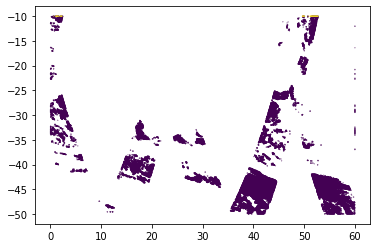

In [56]:
xs = tree.data[idx-1][:,0]
ys = tree.data[idx-1][:,1]
plt.scatter(xs, ys, s=0.05, c=dist)

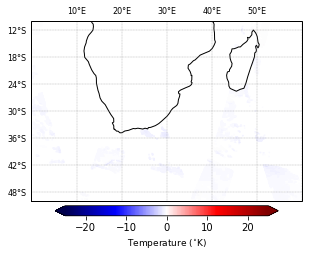

<Figure size 432x288 with 0 Axes>

In [69]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_extent([0, 60, -50, -10], ccrs.PlateCarree())

#gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# img = hycom_free_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
img = plt.scatter(l3['longitude'], l3['latitude'], s=0.05, c=error_diff_l3, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), vmin=-25, vmax=25)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('Temperature ($^{\circ}$K)', fontsize=9)

ax.set_title('')
# plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/vel/VEL_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()